오늘은 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해보았습니다.


In [1]:
import pandas
import tensorflow

import datetime as dt
# import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


# Step 1. 데이터의 전처리

## 1-1. Time 컬럼을 yyyy-mm-dd형식으로 변경해 주었습니다

In [3]:
oldest, latest = data['Time'].min(), data['Time'].max()

In [4]:
oldest

956703932

In [5]:
print(dt.datetime.fromtimestamp(oldest).strftime("%Y-%m-%d %H:%M:%S"))

2000-04-25 23:05:32


In [6]:
# test_time = pd.to_datetime(data['Time'])
test_time = data['Time']
for idx, time in enumerate(test_time):
    test_time[idx] = dt.datetime.fromtimestamp((time)).strftime("%Y-%m-%d %H:%M:%S")
# # test_time.dt.hour
# test_time.dt.date
# test_time[0]

In [7]:
test_time = pd.DataFrame(test_time)

In [8]:
test_time

,Time
0,2000-12-31 22:12:40
1,2000-12-31 22:35:09
2,2000-12-31 22:32:48
3,2000-12-31 22:04:35
4,2001-01-06 23:38:11
...,...
1000204,2000-04-26 02:35:41
1000205,2000-04-25 23:21:27
1000206,2000-04-25 23:19:06
1000207,2000-04-26 02:20:48


In [9]:
data['Time'] = test_time

In [10]:
del test_time

In [11]:
data['Time'].describe()

count                 1000209
unique                 458455
top       2000-11-29 20:06:42
freq                       30
Name: Time, dtype: object

## 1-2. 영화 추천을 위해서는, 평점이 3점 이상인 것만 남겨주었습니다.

아래 cleansing 메소드로 대체해서 사용 \^_\^

In [12]:
# data = data[data['Rating']>=3]

In [13]:
# data['Rating'].describe()

## 1-3. Session ID 필터링

In [14]:
# from pandas_visual_analysis import VisualAnalysis

In [15]:
# VisualAnalysis(data)

In [16]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [17]:
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [18]:
session_length.median()

96.0

# 세션의 길이 최소 : 1, 중간값 : 81, 평균 : 138, 최대 : 1968

1. A 작품을 보고, B작품도 보았다 라는 추천을 하기 위해선, session 길이가 2이상인 것만 남겨주려합니다.
2. 중간값은 81, 평균은 138입니다. 사용자 75%선의 Session 길이가 177입니다. 저는 사용자 75%의 데이터만 남겨주고 그 이상은 삭제할것입니다.

그전에 Session 길이에 대한 감을 잘 파악하기 위해 시각화를 시도해보았습니다.

In [19]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

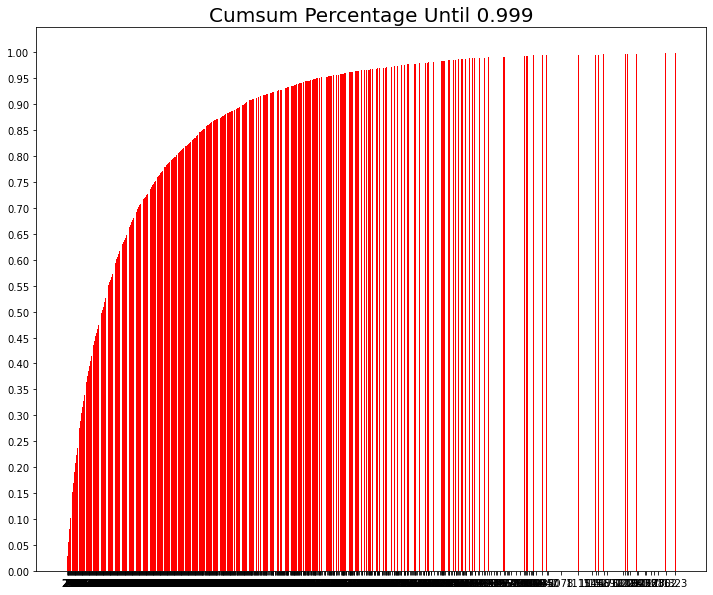

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

# Datathon의 영향으로, x축의 라벨값을 좋게 보여주려고 코드를 수정했는데, ax와 plt의 차이를 더 공부해야겠습니다.

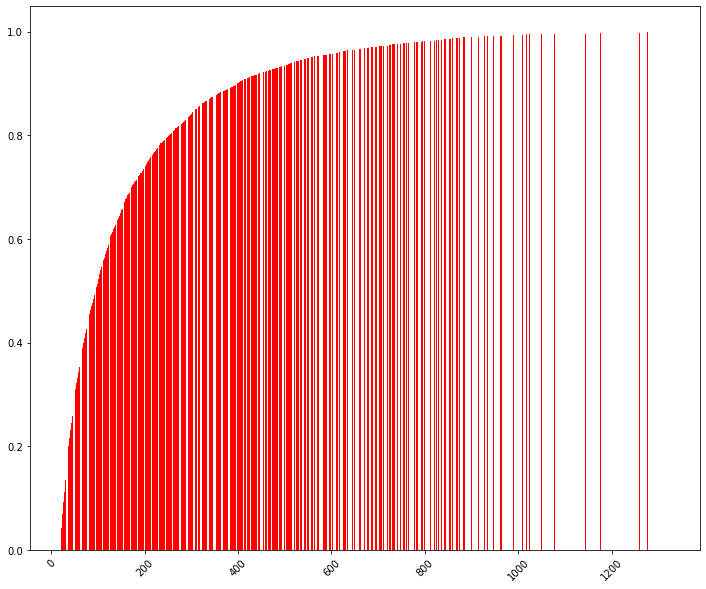

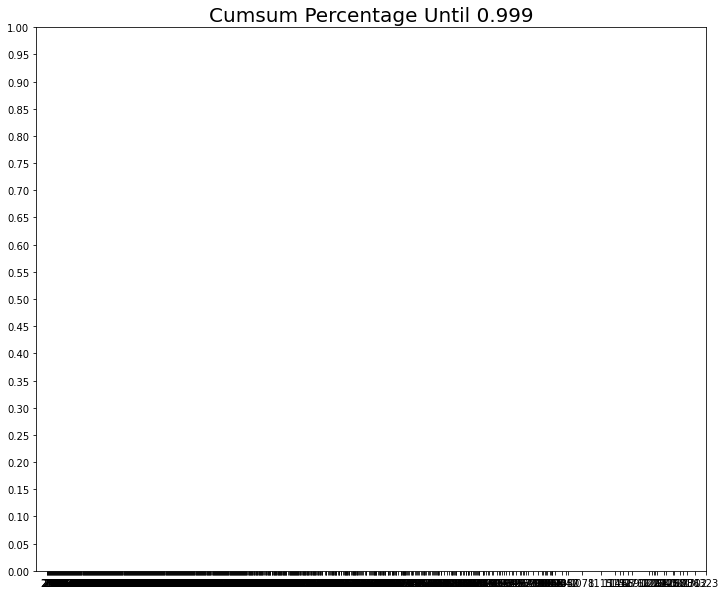

In [21]:
# 이게 젤 낫긴한데 title등의 옵션이사라져버림 ㅎㅎ
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1)

# ax.bar([i for i in range(len(length_percent_cumsum_999.index))], 
#        length_percent_cumsum_999, label='Session길이 누적합')

plt.figure(figsize=(12, 10))
ax.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red', label='Session길이 누적합')
plt.xticks(length_percent_cumsum_999.index)

for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)

plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

# session 길이가 2미만인 그룹  & 177이상인 그룹 & Rating < 3인 그룹 삭제

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, longest, least_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_unpopular_item(data, least_rating)
        data = cleanse_short_session(data, shortest)
        data = cleanse_long_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_long_session(data: pd.DataFrame, longest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len < longest].index
    data = data[data['UserId'].isin(session_use)]
    return data

# def cleanse_unpopular_item(data: pd.DataFrame, least_rating):
#     item_popular = data.groupby('ItemId').size()
#     item_use = item_popular[item_popular >= least_rating].index
#     data = data[data['Rating'].isin(item_use)]
#     return data


def cleanse_unpopular_item(data: pd.DataFrame, least_rating):
    data = data[data['Rating']>=least_rating]
    return data

In [23]:
data = cleanse_recursive(data, shortest=2, longest=177, least_rating=3)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
999863,6039,1081,4,2000-04-25 23:39:49
999864,6039,1083,3,2000-04-25 23:40:51
999865,6039,1086,4,2000-04-25 23:43:02
999866,6039,1088,4,2000-04-25 23:40:19


# 너무 긴 세션을 삭제했더니 전체 컬럼 길이가 너무 짧아져서 후에 삭제해야 할 수도 있을 것 같습니다,,

- cleanse_long_session 주석처리할 경우 : 836477 
- cleanse_long_session 사용할 경우 :308506 

In [24]:
data['Rating'].describe()

count    308506.000000
mean          4.043853
std           0.767743
min           3.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64


# 1-4.  Train / Valid / Test split

`date['TIme']`컬럼을 일자별 데이터로 변경

In [25]:
data['Time']

0         2000-12-31 22:12:40
1         2000-12-31 22:35:09
2         2000-12-31 22:32:48
3         2000-12-31 22:04:35
4         2001-01-06 23:38:11
                 ...         
999863    2000-04-25 23:39:49
999864    2000-04-25 23:40:51
999865    2000-04-25 23:43:02
999866    2000-04-25 23:40:19
999867    2000-04-25 23:36:51
Name: Time, Length: 308506, dtype: object

In [26]:
test_time = pd.to_datetime(data['Time'])
test_time = test_time.dt.date

In [27]:
test_time

0         2000-12-31
1         2000-12-31
2         2000-12-31
3         2000-12-31
4         2001-01-06
             ...    
999863    2000-04-25
999864    2000-04-25
999865    2000-04-25
999866    2000-04-25
999867    2000-04-25
Name: Time, Length: 308506, dtype: object

In [28]:
data['Time'] = test_time
del test_time

In [29]:
data['Time'].max()

datetime.date(2003, 2, 27)

In [30]:
data['Time'].describe()

count         308506
unique           901
top       2000-11-20
freq           23211
Name: Time, dtype: object

In [31]:
couted_date = data.groupby('Time').size()

In [32]:
couted_date

Time
2000-04-25     118
2000-04-26    1784
2000-04-27     618
2000-04-28     605
2000-04-29     375
              ... 
2003-02-21      27
2003-02-22       2
2003-02-24      17
2003-02-25       2
2003-02-27       2
Length: 901, dtype: int64

In [33]:
couted_date = pd.DataFrame(couted_date)
couted_date

,0
Time,
2000-04-25,118
2000-04-26,1784
2000-04-27,618
2000-04-28,605
2000-04-29,375
...,...
2003-02-21,27
2003-02-22,2
2003-02-24,17


In [34]:
date_index = couted_date.index
date_index

Index([2000-04-25, 2000-04-26, 2000-04-27, 2000-04-28, 2000-04-29, 2000-04-30,
       2000-05-01, 2000-05-02, 2000-05-03, 2000-05-04,
       ...
       2003-02-14, 2003-02-15, 2003-02-16, 2003-02-17, 2003-02-20, 2003-02-21,
       2003-02-22, 2003-02-24, 2003-02-25, 2003-02-27],
      dtype='object', name='Time', length=901)

In [35]:
date_values = couted_date.values
date_values.reshape(len(date_index))

array([  118,  1784,   618,   605,   375,    87,  1133,   759,   911,
         814,   564,   263,   370,   689,  1042,   331,   471,  1333,
         344,   494,   340,   840,  1440,   615,   607,   667,   679,
         453,   508,   819,  1663,   946,   314,   654,   878,   819,
         819,  1102,  1443,   819,   497,   460,  1297,   474,   344,
         372,   950,   892,   409,   722,   359,   888,   633,   357,
         376,   628,   613,   763,   804,   493,   425,   657,   706,
         452,   266,   402,  1041,  1374,  1746,  4285,  1748,  1825,
        1318,  1442,   948,   261,   595,   777,   632,   555,   939,
         756,   290,   667,   409,   906,   591,  1301,   299,   476,
         824,   663,   326,   787,   333,   211,   701,  2107,  3076,
        4008,  8399,  2702,  2638,  1309,  2134,  2680,  2159,  1626,
        2300,  1300,  1555,  1100,  1782,  1214,   612,  1965,   719,
        1137,   929,   829,  1168,   816,   898,   915,  1082,   587,
         911,   543,

- train / valid / test 로 나누기 위해 각 날짜 별 데이터의 수를 histogram으로 그려보앗습니다. --> 더해봐야함 ㅠ_ㅠ

In [36]:
# plt.bar(len(date_index),date_values.astype('int'))
# plt.xticks(len(date_index), date_index)
# plt.show()

In [37]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [38]:
tr, test = split_by_date(data, n_days=31)
tr, val = split_by_date(tr, n_days=31)

In [39]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 302928
	 Users: 4473
	 Items: 3420
	 First Time : 2000-04-25
	 Last Time : 2002-12-23

* valid Set Stats Info
	 Events: 2894
	 Users: 28
	 Items: 1082
	 First Time : 2000-05-22
	 Last Time : 2003-01-26

* test Set Stats Info
	 Events: 2680
	 Users: 24
	 Items: 1129
	 First Time : 2000-06-01
	 Last Time : 2003-02-27



In [40]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [41]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# step 2. 미니배치 구성

## SessionDataset

In [42]:
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [43]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
0,1,1193,5,2000-12-31,0
1,1,661,3,2000-12-31,1
2,1,914,3,2000-12-31,2
3,1,3408,4,2000-12-31,3
4,1,2355,5,2001-01-06,4
5,1,1197,3,2000-12-31,5
6,1,1287,5,2000-12-31,6
7,1,2804,5,2000-12-31,7
8,1,594,4,2000-12-31,8
9,1,919,4,2000-12-31,9


In [44]:
tr_dataset.click_offsets


array([     0,     53,    169, ..., 302791, 302809, 302928], dtype=int32)

In [45]:
tr_dataset.session_idx


array([   0,    1,    2, ..., 4470, 4471, 4472])

## Session DataLoader

In [46]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [47]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
0,1,1193,5,2000-12-31,0
1,1,661,3,2000-12-31,1
2,1,914,3,2000-12-31,2
3,1,3408,4,2000-12-31,3
4,1,2355,5,2001-01-06,4
5,1,1197,3,2000-12-31,5
6,1,1287,5,2000-12-31,6
7,1,2804,5,2000-12-31,7
8,1,594,4,2000-12-31,8
9,1,919,4,2000-12-31,9


In [48]:
iter_ex = iter(tr_data_loader)

In [49]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 162  63]
Label Item Idx are :       [ 1 54 58 64]
Previous Masked Input Idx are []


# step 3. 모델 구성

## Evaluation metric

In [50]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## model architecture

batchsize를 64로 변경해 주었습니다.

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [52]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [57]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=32, drop_rate=0.2, lr=0.005, epochs=3, k=20)

In [58]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3420)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 32), (64, 32)]      331584    
_________________________________________________________________
dropout_1 (Dropout)          (64, 32)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3420)                112860    
Total params: 444,444
Trainable params: 444,444
Non-trainable params: 0
_________________________________________________________________


# step 4. 모델 학습

In [59]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [60]:
# train_model(model, args)


Evaluation:   0%|          | 0/44 [00:00<?, ?it/s]


IndexError: index 28 is out of bounds for axis 0 with size 28

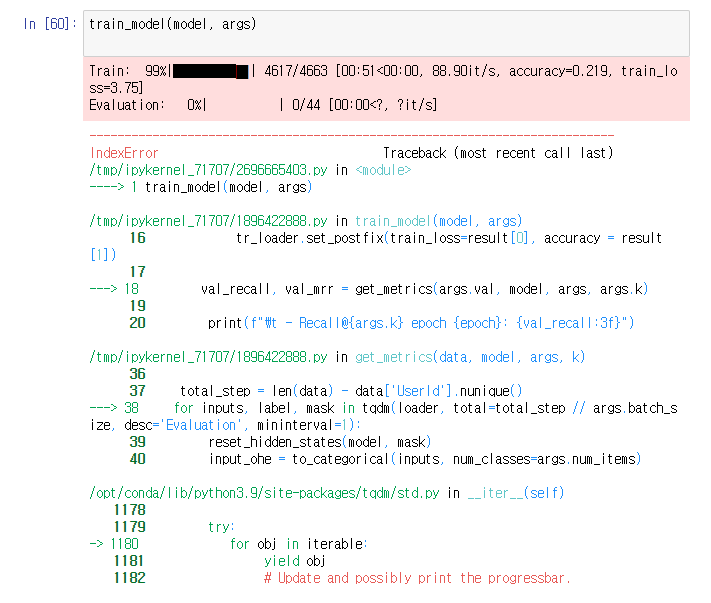

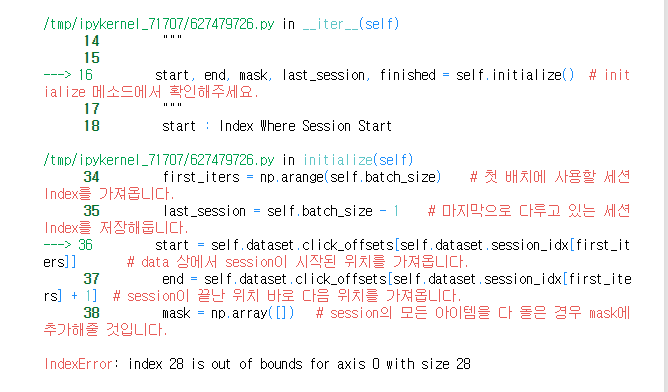

args = Args(tr, val, test, batch_size=32, hsz=25, drop_rate=0.2, lr=0.005, epochs=3, k=20) 

여기서 batch_size를 줄이고 줄이다 보니, 67%에서 멈추던 것이 99프로까진 동아가게 됐으나 여기서 아무리 고쳐도 해당 오류는 고치지 못했습니다. 아무래도 데이터 셋의 크기와 관련이 있을 것 같아서 긴 세션을 없앴던 코드를 없애고 다시돌려보려합니다.

# step 5. 모델 테스트 
어느 정도 성능을 내는지 검증하는 단계

In [62]:
# def test_model(model, args, test):
#     test_recall, test_mrr = get_metrics(test, model, args, 20)
#     print(f"\t - Recall@{args.k}: {test_recall:3f}")
#     print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# test_model(model, args, test)

# step 6. 학습 요소 바꾸기

## 긴 세션 없애는 코드를 주석처리하기

In [63]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [64]:
# test_time = pd.to_datetime(data['Time'])
test_time = data['Time']
for idx, time in enumerate(test_time):
    test_time[idx] = dt.datetime.fromtimestamp((time)).strftime("%Y-%m-%d %H:%M:%S")
# # test_time.dt.hour
# test_time.dt.date
# test_time[0]

In [65]:
def cleanse_recursive(data: pd.DataFrame, shortest, longest, least_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_unpopular_item(data, least_rating)
        data = cleanse_short_session(data, shortest)
#         data = cleanse_long_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

In [66]:
data = cleanse_recursive(data, shortest=2, longest=177, least_rating=3)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000203,6040,1090,3,2000-04-26 02:18:38
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


# 데이터 갈라치기

In [67]:
test_time = pd.to_datetime(data['Time'])
test_time = test_time.dt.date

In [68]:
test_time

0          2000-12-31
1          2000-12-31
2          2000-12-31
3          2000-12-31
4          2001-01-06
              ...    
1000203    2000-04-26
1000205    2000-04-25
1000206    2000-04-25
1000207    2000-04-26
1000208    2000-04-26
Name: Time, Length: 836477, dtype: object

In [69]:
data['Time'] = test_time
del test_time

In [77]:
tr, test = split_by_date(data, n_days=31)
tr, val = split_by_date(tr, n_days=31)

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

## 미니배치~학습

In [78]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
0,1,1193,5,2000-12-31,0
1,1,661,3,2000-12-31,1
2,1,914,3,2000-12-31,2
3,1,3408,4,2000-12-31,3
4,1,2355,5,2001-01-06,4
5,1,1197,3,2000-12-31,5
6,1,1287,5,2000-12-31,6
7,1,2804,5,2000-12-31,7
8,1,594,4,2000-12-31,8
9,1,919,4,2000-12-31,9


In [79]:
tr_dataset.click_offsets


array([     0,     53,    169, ..., 766867, 766986, 767262], dtype=int32)

In [80]:
tr_dataset.session_idx


array([   0,    1,    2, ..., 5846, 5847, 5848])

In [81]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
0,1,1193,5,2000-12-31,0
1,1,661,3,2000-12-31,1
2,1,914,3,2000-12-31,2
3,1,3408,4,2000-12-31,3
4,1,2355,5,2001-01-06,4
5,1,1197,3,2000-12-31,5
6,1,1287,5,2000-12-31,6
7,1,2804,5,2000-12-31,7
8,1,594,4,2000-12-31,8
9,1,919,4,2000-12-31,9


In [82]:
iter_ex = iter(tr_data_loader)

In [83]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 162  63]
Label Item Idx are :       [ 1 54 58 64]
Previous Masked Input Idx are []


In [87]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.2, lr=0.005, epochs=3, k=20)

In [88]:
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3614)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      549900    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3614)                184314    
Total params: 734,214
Trainable params: 734,214
Non-trainable params: 0
_________________________________________________________________


In [89]:
train_model(model, args)


Evaluation:  36%|███▌      | 146/407 [00:28<00:50,  5.18it/s]


	 - Recall@20 epoch 1: 0.680972
	 - MRR@20    epoch 1: 0.296780



Evaluation:  36%|███▌      | 146/407 [00:26<00:48,  5.42it/s]


	 - Recall@20 epoch 2: 0.704730
	 - MRR@20    epoch 2: 0.310891



Evaluation:  36%|███▌      | 146/407 [00:26<00:47,  5.45it/s]

	 - Recall@20 epoch 3: 0.720783
	 - MRR@20    epoch 3: 0.317121



In [90]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  53%|█████▎    | 354/670 [01:00<00:53,  5.87it/s]

	 - Recall@20: 0.773173
	 - MRR@20: 0.355220



# 회고
1. 처음에 UTC TIME으로 작성된 시간을 변환하는데 많은 어려움을 겪었습니다.

`test_time = pd.to_datetime(data['Time'])`과 from datetime import datetime 해서 `dt.fromtimestamp((time))` 이코드의 차이는 뭘까

전자로하니 1970-01-01로 전체 날짜가 변경되어 많은 혼란이있었습니다.

2. Datathon의 영향으로, x축의 라벨값을 좋게 보여주려고 코드를 수정했는데, ax와 plt의 차이를 더 공부해야겠습니다. ~~seaborn만 사용했더니만,, matplotlib는 어렵네요ㅠㅠ~~

3. datetime 와 datetime.datetime의 차이를 공부하기!

4. index 오류는 내가 넣은 데이터와 하이퍼파라미터들이 안맞아서 생기는 문제인거같은데 대체 이부분은 어딜 더 공부해야 알 수있을까. 모델을 하나하나 뜯어봐야하나,,

5. 생각보다 성능이 잘 나오지 않으며, 하이퍼 파라미터를 다르게 줘도 눈에 띄게 성능향상이 되진 않았다.

# 더 공부하고 싶은것

### 데이터톤을 하고 난 이후 시각화에 관심이 많아졌습니다.

1. barchart에서 x축 범위는 일정하게 나눠보여주고, 그래프는 그대로보였으면좋겠다. 그리고 글자가 안곂쳤으면 좋겠다.

In [ ]:
# 그래프가 달라졌음 ㅠ x축 바뀐거도없음
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# plt.bar(x=length_percent_cumsum_999.index,
#         height=length_percent_cumsum_999, color='red')
plt.bar(range(len(length_percent_cumsum_999)),
        length_percent_cumsum_999, color='red')
# plt.xlabel(length_percent_cumsum_999.index)
plt.xticks(length_percent_cumsum_999.index, fontsize=10, rotation=90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [ ]:
# 이게 젤 낫긴한데 title등의 옵션이사라져버림 ㅎㅎ
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1)

# ax.bar([i for i in range(len(length_percent_cumsum_999.index))], 
#        length_percent_cumsum_999, label='Session길이 누적합')

plt.figure(figsize=(12, 10))
ax.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red', label='Session길이 누적합')
plt.xticks(length_percent_cumsum_999.index)

for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)

plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [ ]:
# 글자곂침해결해ㅏ,,
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
# plt.xlabel(length_percent_cumsum_999.index)
plt.xticks(length_percent_cumsum_999.index, fontsize=10, rotation=90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

2. train / valid / test 로 나누기 위해 각 날짜 별 데이터의 수를 histogram으로 그려보기

In [ ]:
plt.bar(len(date_index),date_values.astype('int'))
plt.xticks(len(date_index), date_index)
plt.show()